# Import Library

In [1]:
import pandas as pd
import numpy as np
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk

# Dataset

In [2]:
df = pd.read_csv('data_crawling.csv')

# Missing Value

In [3]:
df.isna().sum()

text    2
dtype: int64

In [4]:
df.dropna(inplace=True)
df.isna().sum()

text    0
dtype: int64

# Deskripsi Data

In [5]:
df.describe()

,text
count,2112
unique,2073
top,❤️
freq,6


# Text preprocessing

Text preprocessing merupakan suatu proses pengubahan bentuk sebuah data menjadi lebih terstruktur, bersih dengan tujuan agar dapat diproses labelling

**Tahap Tahap**
- remove punc,url,username,digits,whitespace
- normalisasi data
- stemming
- stopwords


## Remove punc,url,username,digits,whitespace

In [6]:
df['text'] = df.text.str.lower()
text = list(df['text'].values)
text[0:10]

['kak kalau dibagian surat rekom, petingginya ganyantumin pangkat dan golongannya boleh ga kak?',
 '@holyjune00 aku lupa tapi km 5 yang keterima ga sampe 50% dari total pendaftar',
 '@delviputriii12_ ga apa apa',
 '@rama_aryo saya kemarin isi di yogyakarta selain domisili',
 'kak giman nih kalau lupa correct tidak sedang dapat beasiswa 🥺 sya lupa kk solusinya ap ya',
 'sedih rasanya km sudah masuk ke angkatan 6😢',
 '@delviputriii12_ https://t.me/pendaftarkm6',
 '@ayyu._.nabila gapapa masukin aja',
 '@rama_aryo iya kak masalahnya saya selain provinsi domisil itu diisi jauh dari domisili saya nama grup telenya aapa kak',
 '@yoppietri kak izin bertanya gimana kalo kita ikut organisasi tapi gk punya surat keterangan aktif organisasi, tapi kita ada sertifikat sertifikat pernah jadi panitia dan peserta di organisasi itu, boleh ndk kita taro sertifikat itu kak?']

In [7]:
def remove_punc_etc(text):
    # remove url
    text = [re.sub(r"http\S+","",t) for t in text]
    
    # remove username
    text = [re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)","", t) for t in text]
    
    # remove digits
    text = [t.translate(str.maketrans('','',string.digits)).strip() for t in text]
    
    
    # remove emoji
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    text  = [emoji_pattern.sub(r'', t) for t in text]
    text = [t.replace('🥺','') for t in text]
    
    #remove punc
    text = [t.translate(str.maketrans('','',string.punctuation)).strip() for t in text]
    
    #remove whitespace
    text = [t.replace('  ',' ').strip() for t in text]
    
    
    return text
text_remove_punc = remove_punc_etc(text)
text_remove_punc[0:10]


['kak kalau dibagian surat rekom petingginya ganyantumin pangkat dan golongannya boleh ga kak',
 'aku lupa tapi km yang keterima ga sampe dari total pendaftar',
 'ga apa apa',
 'saya kemarin isi di yogyakarta selain domisili',
 'kak giman nih kalau lupa correct tidak sedang dapat beasiswa sya lupa kk solusinya ap ya',
 'sedih rasanya km sudah masuk ke angkatan',
 '',
 'nabila gapapa masukin aja',
 'iya kak masalahnya saya selain provinsi domisil itu diisi jauh dari domisili saya nama grup telenya aapa kak',
 'kak izin bertanya gimana kalo kita ikut organisasi tapi gk punya surat keterangan aktif organisasi tapi kita ada sertifikat sertifikat pernah jadi panitia dan peserta di organisasi itu boleh ndk kita taro sertifikat itu kak']

## Normalisasi data

In [8]:
norm = pd.read_csv('data_requirement/normalisasi_kata.csv')
def normalisasi(text):
    text = [t.split() for t in text]
    text_ = []

    for t in text:
        c = []
        for j in t:
            if j in norm['singkat'].values:
                hasil = ''.join(norm[norm['singkat'] == j]['hasil'])
                c.append(hasil)
            else:
                c.append(j)
        text_.append(c)
    return [' '.join(t) for t in text_]
text_norm = normalisasi(text_remove_punc)
text_norm[0:10]

['kak kalau dibagian surat rekom petingginya ganyantumin pangkat dan golongannya boleh tidak kak',
 'saya lupa tapi kamu yang keterima tidak sampai dari total pendaftar',
 'tidak apa apa',
 'saya kemarin isi di yogyakarta selain domisili',
 'kak giman nih kalau lupa correct tidak sedang dapat beasiswa saya lupa kk solusinya ap ya',
 'sedih rasanya kamu sudah masuk ke angkatan',
 '',
 'nabila tidak apa-apa masukin saja',
 'iya kak masalahnya saya selain provinsi domisil itu diisi jauh dari domisili saya nama grup telenya aapa kak',
 'kak izin bertanya bagaimana kalau kita ikut organisasi tapi tidak punya surat keterangan aktif organisasi tapi kita ada sertifikat sertifikat pernah jadi panitia dan peserta di organisasi itu boleh tidak kita taro sertifikat itu kak']

## Token

In [9]:
def word_tokenize_wrapper(text):
    text = [nltk.word_tokenize(t) for t in text]
    return text

text_token = word_tokenize_wrapper(text_norm)
print(text_token[0:3])




[['kak', 'kalau', 'dibagian', 'surat', 'rekom', 'petingginya', 'ganyantumin', 'pangkat', 'dan', 'golongannya', 'boleh', 'tidak', 'kak'], ['saya', 'lupa', 'tapi', 'kamu', 'yang', 'keterima', 'tidak', 'sampai', 'dari', 'total', 'pendaftar'], ['tidak', 'apa', 'apa']]


## Stemming

In [10]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in text_token[0:10]:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
print(len(term_dict))
print('----- sample -----')
for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
print(term_dict)

# apply
def stemming(text):
    c  = []
    for text in text_token:
        t_ = []
        for t in text:
            t_.append(stemmer.stem(t))
        c.append(t_)
    hasil = []
    for t in c:
        hasil.append(' '.join(c for c in t ))
    return hasil


text_stemming = stemming(text_token)

76
----- sample -----
{'kak': 'kak', 'kalau': 'kalau', 'dibagian': 'bagi', 'surat': 'surat', 'rekom': 'rekom', 'petingginya': 'petinggi', 'ganyantumin': 'ganyantumin', 'pangkat': 'pangkat', 'dan': 'dan', 'golongannya': 'golong', 'boleh': 'boleh', 'tidak': 'tidak', 'saya': 'saya', 'lupa': 'lupa', 'tapi': 'tapi', 'kamu': 'kamu', 'yang': 'yang', 'keterima': 'terima', 'sampai': 'sampai', 'dari': 'dari', 'total': 'total', 'pendaftar': 'daftar', 'apa': 'apa', 'kemarin': 'kemarin', 'isi': 'isi', 'di': 'di', 'yogyakarta': 'yogyakarta', 'selain': 'selain', 'domisili': 'domisili', 'giman': 'gim', 'nih': 'nih', 'correct': 'correct', 'sedang': 'sedang', 'dapat': 'dapat', 'beasiswa': 'beasiswa', 'kk': 'kk', 'solusinya': 'solusi', 'ap': 'ap', 'ya': 'ya', 'sedih': 'sedih', 'rasanya': 'rasa', 'sudah': 'sudah', 'masuk': 'masuk', 'ke': 'ke', 'angkatan': 'angkat', 'nabila': 'nabila', 'apa-apa': 'apa', 'masukin': 'masukin', 'saja': 'saja', 'iya': 'iya', 'masalahnya': 'masalah', 'provinsi': 'provinsi', 'do

## Stopwords

In [11]:
stopwords_idn = list(pd.read_csv('data_requirement/stopwords_idn.csv').values)
stopwords_ = stopwords_idn+['up','wkwk','a',"bismillah",'min','ya','nya','kak']
def stopwords(text):
    text__ = [t.split() for t in text]
    text_ = []
    for t in text__:
        c = []
        for j in t:
            if j not in stopwords_:
                c.append(j)
        text_.append(c)
    return [' '.join(t) for t in text_]
text_stop = stopwords(text_stemming)
text_stop[0:10]

['surat rekom petinggi ganyantumin pangkat golong',
 'lupa terima total daftar',
 '',
 'kemarin isi yogyakarta domisili',
 'gim nih lupa correct beasiswa lupa kk solusi ap',
 'sedih masuk angkat',
 '',
 'nabila masukin',
 'iya provinsi domisil isi domisili nama grup tele aapa',
 'izin organisasi surat terang aktif organisasi sertifikat sertifikat panitia organisasi taro sertifikat']

In [12]:
print(len(text_stemming))
print(len(text_token))
print(len(text_stop))
print(len(text_norm))
print(len(text_remove_punc))
print(len(text))

2112
2112
2112
2112
2112
2112


# Tahap Akhir

In [13]:
d = {'text_kotor':text,'text_remove_punc':text_remove_punc,'text_norm':text_norm,'token':text_token,'text_stemming':text_stemming,'text_stop':text_stop}
df_ = pd.DataFrame(d)
# df_ = pd.DataFrame(d)

df_

,text_kotor,text_remove_punc,text_norm,token,text_stemming,text_stop
0,"kak kalau dibagian surat rekom, petingginya ga...",kak kalau dibagian surat rekom petingginya gan...,kak kalau dibagian surat rekom petingginya gan...,"[kak, kalau, dibagian, surat, rekom, petinggin...",kak kalau bagi surat rekom petinggi ganyantumi...,surat rekom petinggi ganyantumin pangkat golong
1,@holyjune00 aku lupa tapi km 5 yang keterima g...,aku lupa tapi km yang keterima ga sampe dari t...,saya lupa tapi kamu yang keterima tidak sampai...,"[saya, lupa, tapi, kamu, yang, keterima, tidak...",saya lupa tapi kamu yang terima tidak sampai d...,lupa terima total daftar
2,@delviputriii12_ ga apa apa,ga apa apa,tidak apa apa,"[tidak, apa, apa]",tidak apa apa,
3,@rama_aryo saya kemarin isi di yogyakarta sela...,saya kemarin isi di yogyakarta selain domisili,saya kemarin isi di yogyakarta selain domisili,"[saya, kemarin, isi, di, yogyakarta, selain, d...",saya kemarin isi di yogyakarta selain domisili,kemarin isi yogyakarta domisili
4,kak giman nih kalau lupa correct tidak sedang ...,kak giman nih kalau lupa correct tidak sedang ...,kak giman nih kalau lupa correct tidak sedang ...,"[kak, giman, nih, kalau, lupa, correct, tidak,...",kak gim nih kalau lupa correct tidak sedang da...,gim nih lupa correct beasiswa lupa kk solusi ap
...,...,...,...,...,...,...
2107,cerita inspiratif dari saya peserta msib 4: ng...,cerita inspiratif dari saya peserta msib ngiri...,cerita inspiratif dari saya peserta msib ngiri...,"[cerita, inspiratif, dari, saya, peserta, msib...",cerita inspiratif dari saya serta msib ngirit ...,cerita inspiratif msib ngirit bbh turun
2108,"min, sesekali saia masuk ke feed ini haha 😂",min sesekali saia masuk ke feed ini haha,min sesekali saya masuk ke feed ini haha,"[min, sesekali, saya, masuk, ke, feed, ini, haha]",min sekal saya masuk ke feed ini haha,sekal masuk feed haha
2109,waww ada kamu @fathiyyahazz,waww ada kamu,waww ada kamu,"[waww, ada, kamu]",waww ada kamu,waww
2110,bisa aja capernya,bisa aja capernya,bisa saja capernya,"[bisa, saja, capernya]",bisa saja capernya,capernya


In [17]:
df_.isna().sum()

text_kotor          0
text_remove_punc    0
text_norm           0
token               0
text_stemming       0
text_stop           0
dtype: int64

## Hapus Teks kosong

In [14]:
# while("" in text_stop):
while("" in text_stop):
    text_stop.remove("")
len(text_stop)

1874

## Kata yang sering muncul

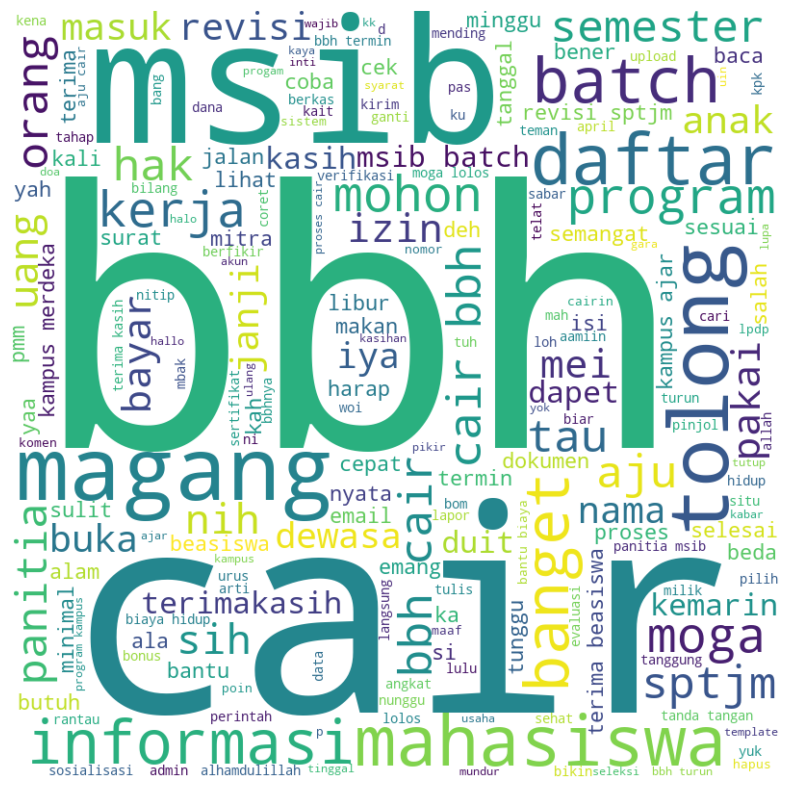

In [15]:
all_words = ' '.join([t for t in text_stop])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Export data clean

setelah melakukan text preprocessing data yang sudah bersih di export guna melakukan tahap selanjutnya yaitu labelling

In [18]:
df = pd.DataFrame({'text_clean':text_stop})
df.to_csv('text_clean.csv',index=False)